In [12]:
import celltypist
from celltypist import models
import scanpy as sc
import pandas as pd 
import numpy as np
import anndata
import re
import h5py
import scipy.sparse as scs
import concurrent.futures
import scanpy.external as sce
import matplotlib.pyplot as plt
from adjustText import adjust_text


In [13]:
def read_mat(h5_con):
    mat = scs.csc_matrix(
        (h5_con['matrix']['data'][:], # Count values
         h5_con['matrix']['indices'][:], # Row indices
         h5_con['matrix']['indptr'][:]), # Pointers for column positions
        shape = tuple(h5_con['matrix']['shape'][:]) # Matrix dimensions
    )
    return mat

# define a function to obeservation (i.e. metadata)

def read_obs(h5con):
    bc = h5con['matrix']['barcodes'][:]
    bc = [x.decode('UTF-8') for x in bc]

    # Initialized the DataFrame with cell barcodes
    obs_df = pd.DataFrame({ 'barcodes' : bc })

    # Get the list of available metadata columns
    obs_columns = h5con['matrix']['observations'].keys()

    # For each column
    for col in obs_columns:
        # Read the values
        values = h5con['matrix']['observations'][col][:]
        # Check for byte storage
        if(isinstance(values[0], (bytes, bytearray))):
            # Decode byte strings
            values = [x.decode('UTF-8') for x in values]
        # Add column to the DataFrame
        obs_df[col] = values
    
    return obs_df
# define a function to construct anndata object from a h5 file
def read_h5_anndata(h5_file):
    h5_con = h5py.File(h5_file, mode = 'r')
    # extract the expression matrix
    mat = read_mat(h5_con)
    # extract gene names
    genes = h5_con['matrix']['features']['name'][:]
    genes = [x.decode('UTF-8') for x in genes]
    # extract metadata
    obs_df = read_obs(h5_con)
    # construct anndata
    adata = anndata.AnnData(mat.T,
                             obs = obs_df)
    # make sure the gene names aligned
    adata.var_names = genes

    adata.var_names_make_unique()
    return adata
def get_last_pattern(inputstr):
    pattern = r"[^/]+(?=$)"
    match = re.search(pattern, inputstr)
    if match:
        return match.group(0)
    else:
        return ""
def random_split_anndata(anndata, num_splits):
    total_cells = anndata.shape[0]
    random_indices = np.random.permutation(total_cells)
    split_size = total_cells // num_splits
    anndata_list = []
    
    for i in range(num_splits):
        start_idx = i * split_size
        end_idx = (i + 1) * split_size if i != num_splits - 1 else total_cells
        
        # Extract the subset of cells for this split
        subset_indices = random_indices[start_idx:end_idx]
        
        # Create a new AnnData object for this subset
        anndata_subset = anndata[subset_indices, :]
        
        # Append to the list
        anndata_list.append(anndata_subset)
        
    return anndata_list

def gen_mpl_labels(
    adata, groupby, exclude=(), ax=None, adjust_kwargs=None, text_kwargs=None
):
    if adjust_kwargs is None:
        adjust_kwargs = {"text_from_points": False}
    if text_kwargs is None:
        text_kwargs = {}

    medians = {}

    for g, g_idx in adata.obs.groupby(groupby).groups.items():
        if g in exclude:
            continue
        medians[g] = np.median(adata[g_idx].obsm["X_umap"], axis=0)

    if ax is None:
        texts = [
            plt.text(x=x, y=y, s=k, **text_kwargs) for k, (x, y) in medians.items()
        ]
    else:
        texts = [ax.text(x=x, y=y, s=k, **text_kwargs) for k, (x, y) in medians.items()]

    adjust_text(texts, **adjust_kwargs)

In [14]:

def Mapping_adata(adata,adata_ref,var_names):
    adata.raw=adata
    adata = adata[:, var_names]
    #adata_ref = adata_ref[:, var_names]
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.scale(adata, max_value=10)
    sc.tl.ingest(adata, adata_ref, obs='leiden')
    return (adata)

In [15]:
meta_data=pd.read_csv("/home//jupyter/hise_meta_data_2023-10-29.csv")

In [16]:
adata=sc.read_h5ad('adata_raw.h5ad')

In [17]:
matching_strings = []

# Iterate through the list and find matching strings
for string in  list(meta_data['file.name.downloaded']):
    match = re.search(r'PB\d{5}-\d+', string)
    if match:
        matching_strings.append(match.group())


In [18]:
meta_data['pbmc_sample_id']=matching_strings

In [19]:
CMV=pd.read_csv('CMV_20220718_UPBR.csv')
BMI=pd.read_csv('BR-BR-Clinical-BMI.csv')
CMV=CMV.merge(BMI, on='subject.subjectGuid', how='left')
meta_data=meta_data.merge(CMV, on='subject.subjectGuid', how='left')

df=adata.obs.merge(meta_data[['pbmc_sample_id', 'subject.biologicalSex',
        'subject.ethnicity', 'subject.partnerCode',
       'subject.race', 'subject.subjectGuid', 'cohort.cohortGuid', 'sample.visitName', 
           'sample.visitDetails', 'subject.birthYear','CMV.IgG.Serology.Result.Interpretation', 'BMI']], on='pbmc_sample_id', how='left')

In [20]:
col_list=['subject.biologicalSex','subject.ethnicity', 'subject.partnerCode',
          'subject.race', 'subject.subjectGuid', 'cohort.cohortGuid', 'sample.visitName', 
          'sample.visitDetails', 'subject.birthYear','CMV.IgG.Serology.Result.Interpretation', 
          'BMI']

In [21]:
def process_sample(sample_id):
    seurat_labels = pd.read_csv(f'Labels_20231030/{sample_id}.csv')
    seurat_labels = seurat_labels[['barcodes', 'predicted.celltype.l1.score', 'predicted.celltype.l1',
                                   'predicted.celltype.l2.score', 'predicted.celltype.l2',
                                   'predicted.celltype.l3.score', 'predicted.celltype.l3',
                                   'predicted.celltype.l2.5.score', 'predicted.celltype.l2.5']]
    
    celltypeist_labels = pd.read_csv(f'Labels_Celltypist/{sample_id}_Low.csv')
    celltypeist_labels = celltypeist_labels[['barcodes', 'predicted_labels', 'majority_voting']]
    celltypeist_labels.columns = ['barcodes', 'predicted_labels_celltypist', 'majority_voting_celltypist']
    
    merged_df = pd.merge(seurat_labels, celltypeist_labels, on='barcodes', how='left')
    
    return merged_df

In [22]:
from concurrent.futures import ThreadPoolExecutor


dfs = []  # To store the resultant dataframes
with ThreadPoolExecutor(max_workers=60) as executor:
    dfs = list(executor.map(process_sample, meta_data['pbmc_sample_id']))

# Combining all dataframes in the list `dfs`
final_df = pd.concat(dfs, ignore_index=True)

In [23]:
df=df.merge(final_df, on='barcodes', how='left')

In [24]:
col_list=['subject.biologicalSex','subject.ethnicity', 'subject.partnerCode',
          'subject.race', 'subject.subjectGuid', 'cohort.cohortGuid', 'sample.visitName', 
          'sample.visitDetails', 'subject.birthYear','CMV.IgG.Serology.Result.Interpretation', 'BMI', 
          'predicted.celltype.l1.score', 'predicted.celltype.l1',
           'predicted.celltype.l2.score', 'predicted.celltype.l2',
           'predicted.celltype.l3.score', 'predicted.celltype.l3',
           'predicted.celltype.l2.5.score', 'predicted.celltype.l2.5',
         'predicted_labels_celltypist', 'majority_voting_celltypist']

In [25]:
for i in col_list:
    adata.obs[i]=list(df[i])

In [26]:
adata.var["mito"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mito"], inplace=True)

... storing 'subject.biologicalSex' as categorical
... storing 'subject.ethnicity' as categorical
... storing 'subject.partnerCode' as categorical
... storing 'subject.race' as categorical
... storing 'subject.subjectGuid' as categorical
... storing 'cohort.cohortGuid' as categorical
... storing 'sample.visitName' as categorical
... storing 'sample.visitDetails' as categorical
... storing 'CMV.IgG.Serology.Result.Interpretation' as categorical
... storing 'BMI' as categorical
... storing 'predicted.celltype.l1' as categorical
... storing 'predicted.celltype.l2' as categorical
... storing 'predicted.celltype.l3' as categorical
... storing 'predicted.celltype.l2.5' as categorical
... storing 'predicted_labels_celltypist' as categorical
... storing 'majority_voting_celltypist' as categorical


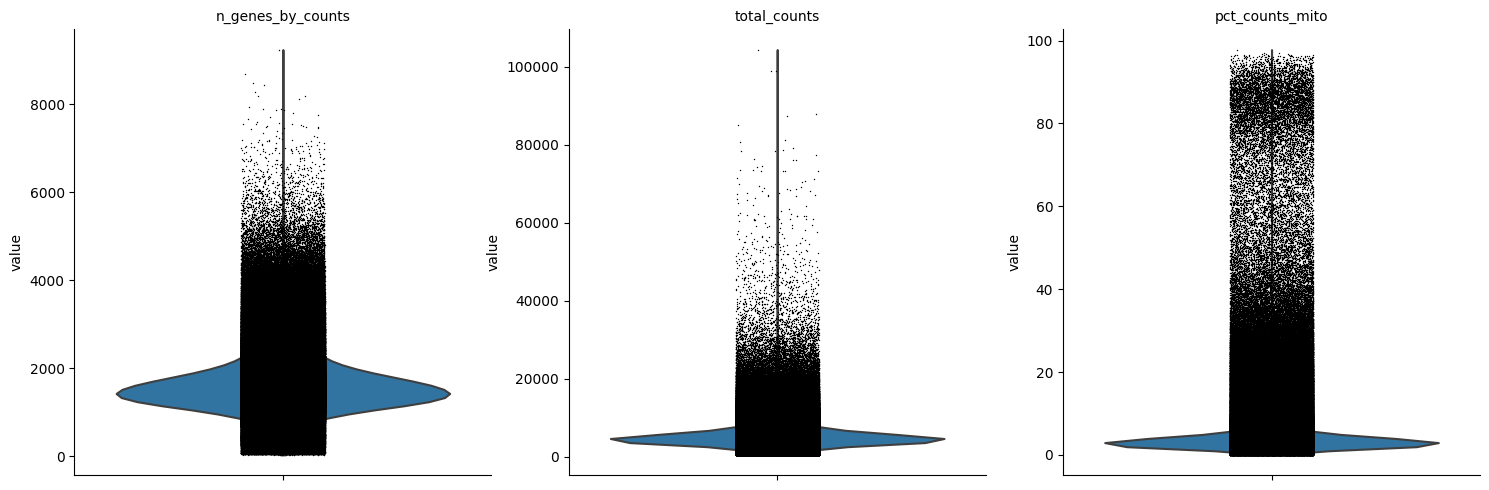

In [27]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mito'],multi_panel=True)

In [28]:
adata=adata[(adata.obs["pct_counts_mito"] <10) & (adata.obs["n_genes"] <5000) &(adata.obs["n_genes"] >200) ]
#adata=adata[(adata.obs["predicted.celltype.l1.score"] >0.5)& (adata.obs["predicted.celltype.l2.score"] >0.5)& (adata.obs["predicted.celltype.l2.5.score"] >0.5) ]

In [29]:
adata_list = random_split_anndata(adata, num_splits=4)

In [30]:
for i in range(len(adata_list)):
    adata_list[i].write_h5ad('temp_02b/adata'+str(i)+'.h5ad')

In [31]:
import os

In [35]:
dir_list = os.listdir('temp_02b/')
dir_list.sort()

In [36]:
dir_list

['.ipynb_checkpoints',
 'adata0.h5ad',
 'adata1.h5ad',
 'adata2.h5ad',
 'adata3.h5ad']

In [37]:
adata_ref=sc.read_h5ad("temp_02b/"+dir_list[1])

In [ ]:
adata_ref.raw=adata_ref
sc.pp.normalize_total(adata_ref, target_sum=1e4)
sc.pp.log1p(adata_ref)
sc.pp.highly_variable_genes(adata_ref, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata_ref = adata_ref[:,adata_ref.var_names[adata_ref.var['highly_variable']]]
sc.pp.scale(adata_ref, max_value=10)
sc.pp.pca(adata_ref)
sc.pp.neighbors(adata_ref,n_neighbors=50, n_pcs=30)
sc.tl.umap(adata_ref)
sc.tl.leiden(adata_ref,resolution=1.2)

In [ ]:
#adata_ref=adata_ref.raw.to_adata()
#adata_ref.write_h5ad('02B_Processed_h5ad/adata0.h5ad')

In [4]:
#adata_ref=sc.read_h5ad('02B_Processed_h5ad/adata0.h5ad')

In [ ]:
for i in range(2,5):
    adata_Q=sc.read_h5ad("temp_02b/"+dir_list[i])
    adata_processed=Mapping_adata(adata_Q, adata_ref, adata_ref.var_names[adata_ref.var['highly_variable']])
    adata_processed=adata_processed.raw.to_adata()
    adata_processed.write_h5ad('02B_Processed_h5ad/adata'+str(i)+'.h5ad')

In [ ]:
dir_list = os.listdir('02B_Processed_h5ad/')
dir_list

In [ ]:
from concurrent.futures import ThreadPoolExecutor
import scanpy as sc

def read_h5ad_file(file_name):
    try:
        return sc.read_h5ad('02B_Processed_h5ad/' + file_name)
    except Exception as e:
        print(f'Error reading {file_name}: {e}')
        return None

# List of directories (Replace with your actual directory list)
dir_list = os.listdir('02B_Processed_h5ad/')

# Parallel execution
with ThreadPoolExecutor(max_workers=10) as executor:
    h5_list = list(executor.map(read_h5ad_file, dir_list))

# Remove None values from the list (in case of errors)
h5_list = [result for result in h5_list if result is not None]

In [ ]:
adata = anndata.concat(h5_list)
adata.obs.index = adata.obs['barcodes']
del h5_list

In [ ]:
adata.raw=adata

In [ ]:
#create a list of colors
colors = ['#FDC086','#FFFF99','#F0027F','#BF5B17','#666666',
          '#1B9E77','#D95F02','#7570B3','#E7298A','#66A61E','#E6AB02','#A6761D','#666666',
          '#A6CEE3','#1F78B4','#B2DF8A','#33A02C','#FB9A99','#E31A1C','#FDBF6F','#FF7F00',
          '#CAB2D6','#6A3D9A','#FFFF99','#B15928','#FBB4AE','#B3CDE3','#CCEBC5','#DECBE4',
          '#FED9A6','#FFFFCC','#E5D8BD','#FDDAEC','#F2F2F2','#B3E2CD','#FDCDAC','#CBD5E8',
          '#F4CAE4','#E6F5C9','#FFF2AE','#F1E2CC','#CCCCCC','#E41A1C','#377EB8','#4DAF4A',
          '#984EA3','#FF7F00','#FFFF33','#A65628','#F781BF','#999999','#66C2A5','#FC8D62',
          '#8DA0CB','#E78AC3','#A6D854','#FFD92F','#E5C494','#B3B3B3','#8DD3C7','#FFFFB3',
          '#BEBADA','#FB8072','#80B1D3','#FDB462','#B3DE69','#FCCDE5','#D9D9D9','#BC80BD',
          '#CCEBC5','#FFED6F']
B_cells= ["B intermediate","B memory","B naive","Plasmablast"]
Myeloid=["CD14 Mono","CD16 Mono","ASDC","cDC1","cDC2","pDC"]
T_cells=[  "CD4 CTL","CD4 Naive","CD4 TCM","CD4 TEM","CD8 Naive",
         "CD8 TCM","CD8 TEM","CD8 TEMRA","dnT","gdT","Treg Memory","Treg Naive"]
left_over=[value for value in adata.obs['predicted.celltype.l2.5'].unique() if value not in B_cells+Myeloid+T_cells]

In [ ]:
Myeloid.sort()
T_cells.sort()
B_cells.sort()
T_cells = dict(zip(T_cells, colors[0:12]))
B_cells = dict(zip(B_cells, colors[12:17]))
Myeloid = dict(zip(Myeloid, colors[17:25]))
left_over = dict(zip(left_over, colors[26:37]))
color_dict=merged_dict = {**T_cells, **B_cells, **Myeloid,**left_over}


In [ ]:
with plt.rc_context({"figure.figsize": (5, 5), "figure.dpi": 500, "figure.frameon": False}):
    ax=sc.pl.umap(adata, color=['predicted.celltype.l2.5'], size=1,show=False,legend_loc=None,ncols=1 ,palette=color_dict,frameon=False)
    gen_mpl_labels(
        adata,
        "predicted.celltype.l2.5",  # This was before we had the `nan` behaviour
        ax=ax,
        adjust_kwargs=dict(arrowprops=dict(arrowstyle='--', color='black')),
        text_kwargs=dict(fontsize=10),)

In [ ]:
with plt.rc_context({"figure.figsize": (5, 5), "figure.dpi": 500, "figure.frameon": False}):
    ax=sc.pl.umap(adata, color=['leiden'], size=1,show=False,legend_loc=None,ncols=1 ,frameon=False)
    gen_mpl_labels(
        adata,
        "leiden",  # This was before we had the `nan` behaviour
        ax=ax,
        adjust_kwargs=dict(arrowprops=dict(arrowstyle='-', color='black')),
        text_kwargs=dict(fontsize=10),)

In [ ]:
sc.pl.umap(adata, color=['leiden','predicted.celltype.l2.5','majority_voting_celltypist'], size=2,show=False,ncols=1 ,frameon=False)

In [ ]:
plt.rcParams['figure.figsize'] = [3, 3]
sc.pl.umap(adata, color=['CD3E','CD3D','CD8A','CD4'], sort_order=False, use_raw=False,size=0.1,show=False,ncols=2,vmax=1,frameon=False)

In [ ]:
sc.pl.umap(adata, color=['CD3E','CD3D','CD8A','CD4'],  use_raw=False,size=0.1,show=False,ncols=2,frameon=False)

In [46]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [ ]:

sc.pp.highly_variable_genes(adata)

adata = adata[:, adata.var_names[adata.var['highly_variable']]]


In [22]:
sc.pp.scale(adata)

In [23]:
sc.tl.pca(adata, svd_solver='arpack')


ImportError: 
please install harmonypy:

	pip install harmonypy

In [ ]:
sce.pp.harmony_integrate(adata, 'cohort.cohortGuid',max_iter_harmony = 30)

2023-10-31 03:43:03,203 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
Computing initial centroids with sklearn.KMeans...


In [ ]:
sc.pp.neighbors(adata, n_neighbors=50,use_rep='X_pca_harmony', n_pcs=30)
sc.tl.umap(adata)